Epoch 1/100


/home/shashank-jangde/Downloads/Solar Internship/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


645/645 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 14634.8301 - val_loss: 4347.3306
Epoch 2/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8914.6650 - val_loss: 3100.9248
Epoch 3/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6766.9819 - val_loss: 2776.9966
Epoch 4/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5351.2720 - val_loss: 2156.1040
Epoch 5/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4256.0068 - val_loss: 1958.6708
Epoch 6/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3558.2151 - val_loss: 1852.3503
Epoch 7/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2970.8000 - val_loss: 1796.1359
Epoch 8/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2572.7322 - val_loss: 1750.3802
Epoch 9/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2357.0237 - val_loss: 1734.8215
Epoch 10/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2179.0178 - val_loss: 1740.4058
Epoch 11/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2074.4285 - val_lo

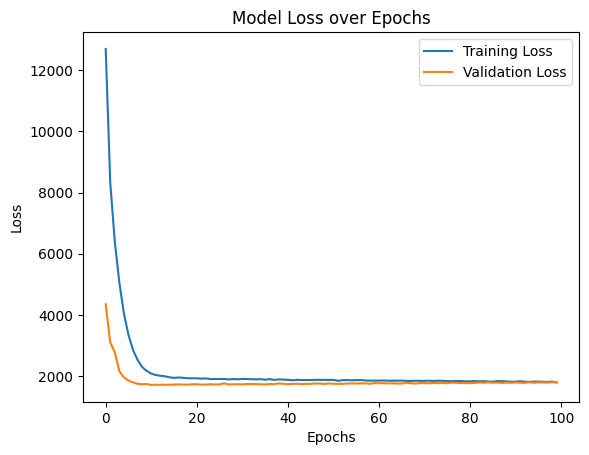

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the file paths
parent = "./CMAPSSData/processed_data/"
train_file = parent + 'train_FD001.csv'
test_file = parent + 'test_FD001.csv'

# Load the datasets
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Define feature and target columns
feature_columns = [f"Operation Setting {j}" for j in range(1, 4)] + [f"Sensor {j}" for j in range(1, 22)]
target_column = "CurrentRUL"

# Split data into features and target
X_train = train_data[feature_columns]
y_train = train_data[target_column]
X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 1: Use Random Forest to identify important features
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get the feature importances from Random Forest
feature_importances = rf.feature_importances_

# Sort the features based on importance (descending)
sorted_idx = np.argsort(feature_importances)[::-1]

# Select the top N features based on importance
top_n_features = 15  # You can adjust this value
X_train_selected = X_train_scaled[:, sorted_idx[:top_n_features]]
X_test_selected = X_test_scaled[:, sorted_idx[:top_n_features]]

# Step 2: Reshape the data for LSTM input (samples, time steps, features)
# Assuming each row is a single time step
X_train_selected = X_train_selected.reshape((X_train_selected.shape[0], 1, X_train_selected.shape[1]))
X_test_selected = X_test_selected.reshape((X_test_selected.shape[0], 1, X_test_selected.shape[1]))

# Step 3: Build the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_selected.shape[1], X_train_selected.shape[2])))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Train the LSTM model
history = model.fit(X_train_selected, y_train, epochs=100, batch_size=32, validation_data=(X_test_selected, y_test))

# Step 5: Make predictions
y_pred = model.predict(X_test_selected)

# Step 6: Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")

# Optionally, plot the training/validation loss over epochs to check for overfitting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
